In [ ]:
%%time
import os
import pandas as pd
import wbdata
import plotly.express as px
from moviepy.editor import ImageSequenceClip
import numpy as np
import plotly.io as pio
pio.kaleido.scope._debug = True

# Import data
# Define the indicator for population (SP.POP.TOTL) and GDP per capita (NY.GDP.PCAP.CD)
indicator = {
    'SP.POP.TOTL': 'total_population',
    'NY.GDP.PCAP.CD': 'gdp_per_capita',
}

# Fetch data for all countries
data = wbdata.get_dataframe(indicator)
data.reset_index(inplace=True)
data.rename(columns={'country': 'Country', 'date': 'Year'}, inplace=True)
data['Year'] = pd.to_numeric(data['Year'])

# Handle missing values
data['gdp_per_capita'] = data['gdp_per_capita'].fillna(0)
data['total_population'] = data['total_population'].fillna(0)

# Filter data for valid years
df = data[(data['Year'] <= 2023) & (data['Year'] >= 1960)]
df.sort_values(by='Year', inplace=True)

# Ensure no missing values in 'gdp_per_capita' and filter years from 2000 onwards
df_cleaned = df[(df["gdp_per_capita"].notna()) & (df["Year"] >= 1960)].copy()

# Categorize 'gdp_per_capita' into bins
bins = [0, 1000, 5000, 10000, 20000, 50000, np.inf]
labels = ['<1k', '1k-5k', '5k-10k', '10k-20k', '20k-50k', '>50k']
df_cleaned['gdp_category'] = pd.cut(
    df_cleaned['gdp_per_capita'],
    bins=bins,
    labels=labels,
    right=False
)

# Define the category order and consistent color mapping
category_orders = {'gdp_category': labels}

# Choose a qualitative color palette with distinct colors
colors = px.colors.qualitative.Set1[:len(labels)]
# If not enough colors, extend with another palette
if len(colors) < len(labels):
    colors += px.colors.qualitative.Set2[:len(labels) - len(colors)]

# Map each category to a specific color
color_discrete_map = dict(zip(labels, colors))

# Directory to save frames
frames_dir = "choropleth_frames_map"
# Remove if already exists
if os.path.exists(frames_dir):
    import shutil
    shutil.rmtree(frames_dir)
os.makedirs(frames_dir, exist_ok=True)

# Save each frame as an image
unique_years = sorted(df_cleaned['Year'].unique())
for i, year in enumerate(unique_years):
    # Filter data for the current year
    filtered_df = df_cleaned[df_cleaned["Year"] == year]

    # Create a DataFrame that contains all categories for the current year
    all_categories_df = pd.DataFrame({
        'Country': [None]*len(labels),
        'Year': [year]*len(labels),
        'gdp_per_capita': [None]*len(labels),
        'gdp_category': labels
    })

    # Combine filtered_df with all_categories_df
    filtered_df_with_all_categories = pd.concat([filtered_df, all_categories_df], ignore_index=True)

    # Create the choropleth map for the current year using 'gdp_category'
    frame_fig = px.choropleth(
        filtered_df_with_all_categories, 
        locations='Country', 
        color='gdp_category',
        hover_name='Country',
        hover_data={'gdp_per_capita': True},
        locationmode='country names',
        color_discrete_map=color_discrete_map,
        category_orders=category_orders,
        labels={
            'gdp_category': 'GDP per Capita (USD)',
            'gdp_per_capita': 'GDP per Capita',
        },
    )
    # frame_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

    # Add country borders and adjust the map view
    frame_fig.update_geos(
        showcountries=True, 
        countrycolor="grey",
        projection_type="natural earth",
    )

    # Adjust figure layout
    frame_fig.update_layout(
        # height=600,
        title_text=f"GDP Per Capita by Country - {int(year)}",
        title_x=0.1, # Center the title
        title_y=0.95, # Adjust the title position
    )

    # size of the image
    frame_fig.update_layout(
        width=1920,
        height=1080,
    )

    # increase the font size of the title and legend
    frame_fig.update_layout(
        title_font_size=50,
        legend_title_font_size=34,
        legend_font_size=22,
    )

    # add text annotation for the source
    frame_fig.add_annotation(
        text='''Source: World Bank Data\n
        Author: Dr. Muhammad Aammar Tufail\n
        www.codanics.com''',
        xref="paper", yref="paper",
        x=0.99, y=0.05,
        showarrow=False,
        font=dict(size=20, color="grey"),
    )

    # Save the frame image using Kaleido
    frame_filename = os.path.join(frames_dir, f"frame_{i:03d}.png")
    frame_fig.write_image(frame_filename, engine="kaleido")    

# Collect image file paths
image_files = [
    os.path.join(frames_dir, f)
    for f in sorted(os.listdir(frames_dir))
    if f.endswith('.png')
]

fps = 4.0  # Frames per second

# Create the clip from image sequence
clip = ImageSequenceClip(image_files, fps=fps)

# Directory to save the video
output_dir = "./choropleth_map_animation"
os.makedirs(output_dir, exist_ok=True)

# Save as MP4
clip.write_videofile(
    os.path.join(output_dir, "animated_choropleth_map.mp4"),
    fps=fps,
    codec="libx264",
    audio=False
)

# Optional: Save HD video with higher bitrate
clip.write_videofile(
    os.path.join(output_dir, "animated_choropleth_map_HD.mp4"),
    fps=fps,
    codec="libx264",
    preset="medium",
    bitrate="3000k",
    audio=False,
    ffmpeg_params=['-pix_fmt', 'yuv420p']
)
fps = 0.5  # Frames per second

# Create the clip from image sequence
clip = ImageSequenceClip(image_files, fps=fps)
# Save as GIF
clip.write_gif(
    os.path.join(output_dir, "animated_choropleth_map.gif"),
    fps=fps
)

# # Display the GIF file from the output directory (if running in a notebook)
# from IPython.display import Image as IPythonImage
# IPythonImage(filename=os.path.join(output_dir, "animated_choropleth_map.gif"))

# remove the frames directory
import shutil
shutil.rmtree(frames_dir)
print("Frames directory removed successfully!")

# reel


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA colu

Moviepy - Building video ./choropleth_map_animation_reel/animated_choropleth_map_reel.mp4.
Moviepy - Writing video ./choropleth_map_animation_reel/animated_choropleth_map_reel.mp4



Moviepy - Done !
Moviepy - video ready ./choropleth_map_animation_reel/animated_choropleth_map_reel.mp4
Moviepy - Building video ./choropleth_map_animation_reel/animated_choropleth_map_HD_reel.mp4.
Moviepy - Writing video ./choropleth_map_animation_reel/animated_choropleth_map_HD_reel.mp4



Moviepy - Done !
Moviepy - video ready ./choropleth_map_animation_reel/animated_choropleth_map_HD_reel.mp4
MoviePy - Building file ./choropleth_map_animation_reel/animated_choropleth_map_reel.gif with imageio.


CPU times: user 1min 41s, sys: 3.44 s, total: 1min 44s
Wall time: 2min 8s


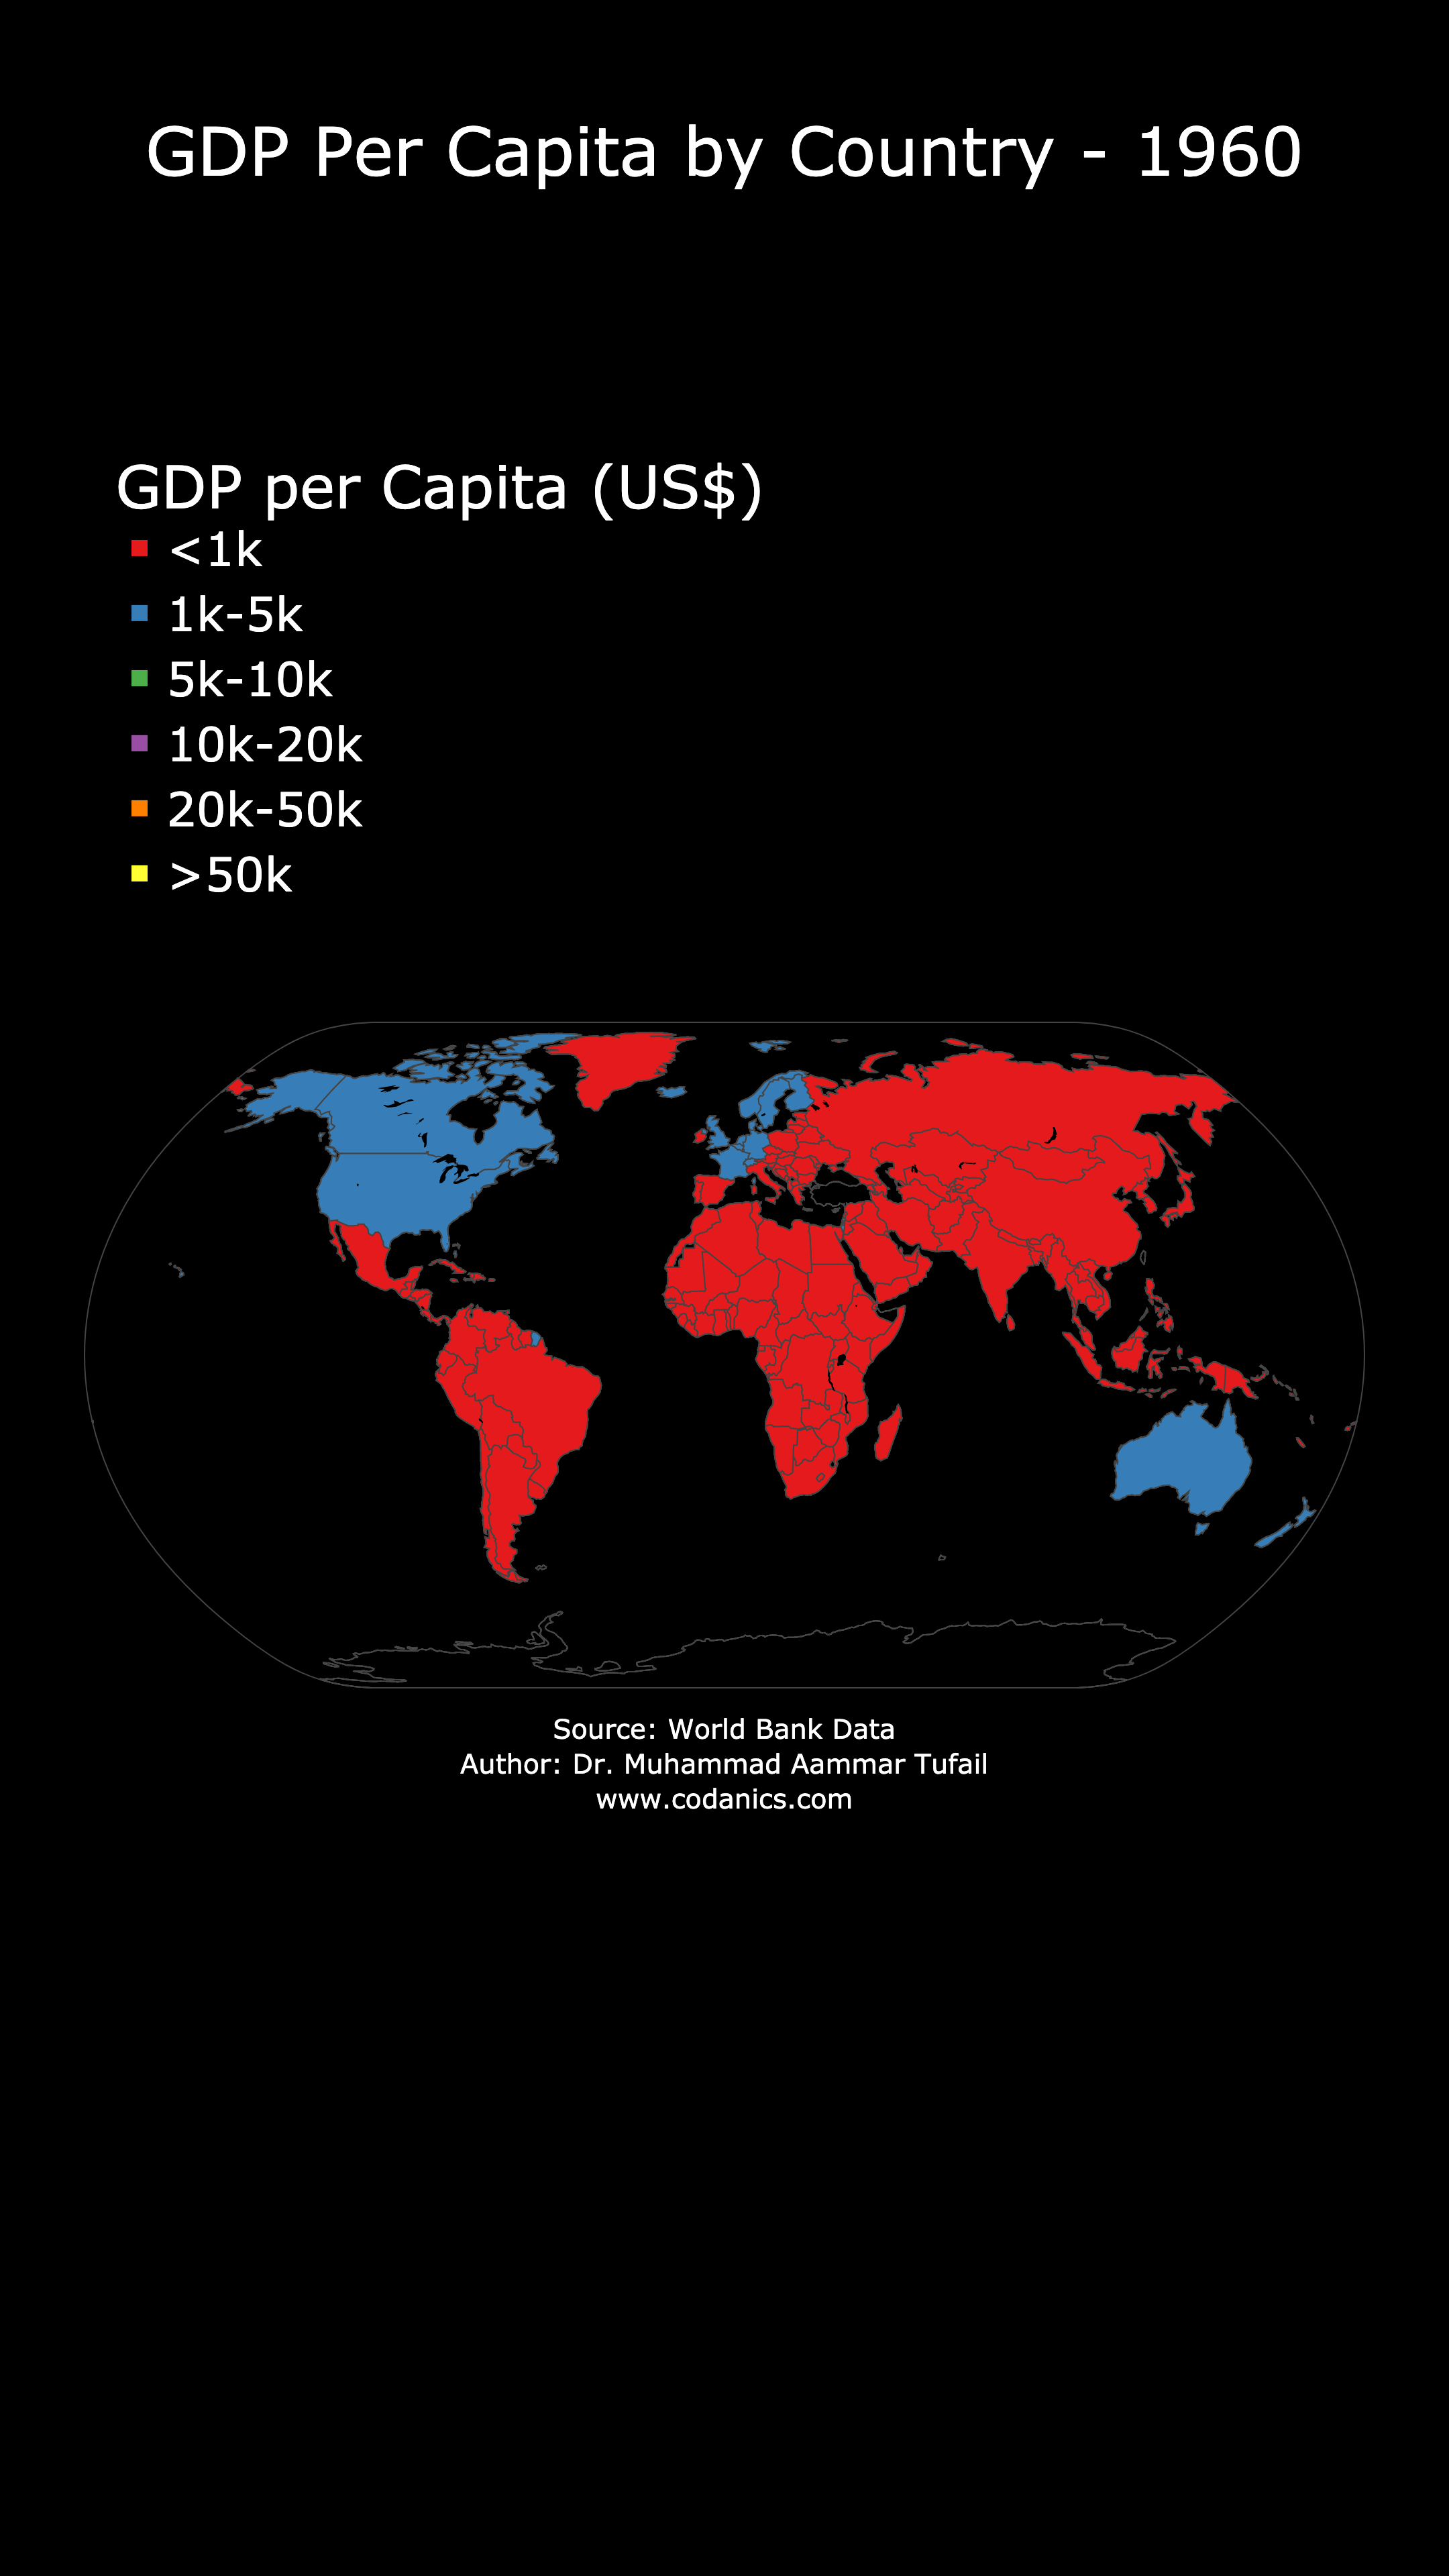

In [ ]:
%%time
import os
import pandas as pd
import wbdata
import plotly.express as px
from moviepy.editor import ImageSequenceClip
import numpy as np
import plotly.io as pio

# Ensure Kaleido is properly installed and up-to-date
# pip install -U kaleido

# Import data
# Define the indicator for population (SP.POP.TOTL) and GDP per capita (NY.GDP.PCAP.CD)
indicator = {
    'SP.POP.TOTL': 'total_population',
    'NY.GDP.PCAP.CD': 'gdp_per_capita',
}

# Fetch data for all countries
data = wbdata.get_dataframe(indicator)
data.reset_index(inplace=True)
data.rename(columns={'country': 'Country', 'date': 'Year'}, inplace=True)
data['Year'] = pd.to_numeric(data['Year'])

# Handle missing values
data['gdp_per_capita'] = data['gdp_per_capita'].fillna(0)
data['total_population'] = data['total_population'].fillna(0)

# Filter data for valid years
df = data[(data['Year'] <= 2023) & (data['Year'] >= 1960)]
df.sort_values(by='Year', inplace=True)

# Ensure no missing values in 'gdp_per_capita' and filter years from 1960 onwards
df_cleaned = df[(df["gdp_per_capita"].notna()) & (df["Year"] >= 1960)].copy()

# Categorize 'gdp_per_capita' into bins
bins = [0, 1000, 5000, 10000, 20000, 50000, np.inf]
labels = ['<1k', '1k-5k', '5k-10k', '10k-20k', '20k-50k', '>50k']
df_cleaned['gdp_category'] = pd.cut(
    df_cleaned['gdp_per_capita'],
    bins=bins,
    labels=labels,
    right=False
)

# Define the category order and consistent color mapping
category_orders = {'gdp_category': labels}

# Choose a qualitative color palette with distinct colors
colors = px.colors.qualitative.Set1[:len(labels)]
# If not enough colors, extend with another palette
if len(colors) < len(labels):
    colors += px.colors.qualitative.Set2[:len(labels) - len(colors)]

# Map each category to a specific color
color_discrete_map = dict(zip(labels, colors))

# Directory to save frames
frames_dir = "choropleth_frames_map_reel"
# Remove if already exists
if os.path.exists(frames_dir):
    import shutil
    shutil.rmtree(frames_dir)
os.makedirs(frames_dir, exist_ok=True)

# Save each frame as an image
unique_years = sorted(df_cleaned['Year'].unique())
for i, year in enumerate(unique_years):
    # Filter data for the current year
    filtered_df = df_cleaned[df_cleaned["Year"] == year]

    # Create a DataFrame that contains all categories for the current year
    all_categories_df = pd.DataFrame({
        'Country': [None]*len(labels),
        'Year': [year]*len(labels),
        'gdp_per_capita': [None]*len(labels),
        'gdp_category': labels
    })

    # Combine filtered_df with all_categories_df
    filtered_df_with_all_categories = pd.concat([filtered_df, all_categories_df], ignore_index=True)

    # Create the choropleth map for the current year using 'gdp_category'
    frame_fig = px.choropleth(
        filtered_df_with_all_categories, 
        locations='Country', 
        color='gdp_category',
        hover_name='Country',
        hover_data={'gdp_per_capita': True},
        locationmode='country names',
        color_discrete_map=color_discrete_map,
        category_orders=category_orders,
        labels={
            'gdp_category': 'GDP per Capita (US$)',
            'gdp_per_capita': 'GDP per Capita',
        },
    )

    # Adjust figure layout for 9:16 aspect ratio
    frame_fig.update_layout(
        width=1080,    # Width for 9:16 aspect ratio
        height=1920,   # Height for 9:16 aspect ratio
        title_text=f"GDP Per Capita by Country - {int(year)}",
        title_x=0.5,   # Center the title horizontally
        title_y=0.95,  # Adjust the title position vertically
        margin=dict(l=10, r=10, t=150, b=50),  # Adjust margins for title and legend
        legend=dict(
            orientation="v",
            yanchor="top",
            y=0.90,
            xanchor="center",
            x=0.3,
            bgcolor='rgba(0,0,0,0)',  # Transparent background
        ),

        paper_bgcolor='black',
        plot_bgcolor='black',
        title_font=dict(size=50, color='white'),
        legend_title_font=dict(size=44, color='white'),
        legend_font=dict(size=35, color='white'),
        font_color='white',
    )

    # Add country borders and adjust the map view
    frame_fig.update_geos(
        showcountries=True,
        countrycolor="grey",
        projection_type="natural earth",
        projection_scale=0.9,         # Adjust projection scale to fill vertical space
        # center={'lat': 0, 'lon': 0}, # Center the map
        landcolor='black',
        oceancolor='black',
        lakecolor='black',
        bgcolor='black',
    )

    # Add text annotation for the source
    frame_fig.add_annotation(
        text='Source: World Bank Data<br>Author: Dr. Muhammad Aammar Tufail<br>www.codanics.com',
        xref="paper", yref="paper",
        x=0.5, y=0.3,
        showarrow=False,
        font=dict(size=20, color="white"),
        align='center',
    )

    # Save the frame image using Kaleido
    frame_filename = os.path.join(frames_dir, f"frame_{i:03d}.png")
    frame_fig.write_image(frame_filename, engine="kaleido", scale=2)    

# Collect image file paths
image_files = [
    os.path.join(frames_dir, f)
    for f in sorted(os.listdir(frames_dir))
    if f.endswith('.png')
]

fps = 4.0  # Frames per second

# Create the clip from image sequence
clip = ImageSequenceClip(image_files, fps=fps)

# Directory to save the video
output_dir = "./choropleth_map_animation_reel"
os.makedirs(output_dir, exist_ok=True)

# Save as MP4 with 9:16 aspect ratio
clip.write_videofile(
    os.path.join(output_dir, "animated_choropleth_map_reel.mp4"),
    fps=fps,
    codec="libx264",
    audio=False
)

# Optional: Save HD video with higher bitrate
clip.write_videofile(
    os.path.join(output_dir, "animated_choropleth_map_HD_reel.mp4"),
    fps=fps,
    codec="libx264",
    preset="medium",
    bitrate="3000k",
    audio=False,
    ffmpeg_params=['-pix_fmt', 'yuv420p']
)

fps = 0.5  # Frames per second for GIF

# Create the clip from image sequence
clip = ImageSequenceClip(image_files, fps=fps)

# Save as GIF
clip.write_gif(
    os.path.join(output_dir, "animated_choropleth_map_reel.gif"),
    fps=fps
)

# # Display the GIF file from the output directory (if running in a notebook)
# from IPython.display import Image as IPythonImage
# IPythonImage(filename=os.path.join(output_dir, "animated_choropleth_map_reel.gif"))


# remove the frames directory
import shutil
shutil.rmtree(frames_dir)
print("Frames directory removed successfully!")